# Big Data - TP #2

El objetivo de este TP es hacer una limpieza y análisis de la EPH. Asimismo, predecir si una persona es o no pobre
utilizando datos distintos al ingreso usando las metodologías vistas en clase.

In [67]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.api as sm     

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

## Parte I: Analizando la base

In [2]:
# Abrimos el archivo y vemos las primeras cinco filas
eph_indiv = pd.read_excel("../datasets/usu_individual_T123.xlsx")
eph_indiv.head(5)

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH
0,TQRMNORVWHLMKOCDEOHCH00720228,2023,1,1,5,0,44,N,91,112,...,10.0,9,79700.0,6,6.0,5,NaN,7.0,5,133
1,TQRMNOPSTHKMKPCDEOHCH00781447,2023,1,1,1,1,44,N,91,190,...,6.0,5,180000.0,9,10.0,9,NaN,10.0,9,200
2,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,1,1,44,N,91,134,...,8.0,8,145000.0,9,9.0,8,NaN,9.0,8,140
3,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,2,1,44,N,91,134,...,8.0,8,145000.0,9,9.0,8,NaN,9.0,8,140
4,TQRMNOQYTHMNKSCDEOHCH00803178,2023,1,1,1,1,44,N,91,120,...,12.0,12,0.0,12,12.0,12,NaN,12.0,12,0


In [3]:
#Resumen de la base de datos
eph_indiv.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48638 entries, 0 to 48637
Data columns (total 177 columns):
 #    Column      Dtype  
---   ------      -----  
 0    CODUSU      object 
 1    ANO4        int64  
 2    TRIMESTRE   int64  
 3    NRO_HOGAR   int64  
 4    COMPONENTE  int64  
 5    H15         int64  
 6    REGION      int64  
 7    MAS_500     object 
 8    AGLOMERADO  int64  
 9    PONDERA     int64  
 10   CH03        int64  
 11   CH04        int64  
 12   CH05        object 
 13   CH06        int64  
 14   CH07        int64  
 15   CH08        float64
 16   CH09        int64  
 17   CH10        int64  
 18   CH11        int64  
 19   CH12        int64  
 20   CH13        int64  
 21   CH14        float64
 22   CH15        int64  
 23   CH15_COD    float64
 24   CH16        int64  
 25   CH16_COD    float64
 26   NIVEL_ED    int64  
 27   ESTADO      int64  
 28   CAT_OCUP    int64  
 29   CAT_INAC    int64  
 30   IMPUTA      float64
 31   PP02C1      int64  
 32   

In [4]:
#2a) Eliminen todas las observaciones que no corresponden a los aglomerados de CABA o Gran Buenos Aires.

#El siguiente código toma el índice de aquellas observaciones para las que el aglomerado no es ni CABA (32) ni Gran Buenos Aires (33), y elimina las filas que cumplen esa condición. 

eph_indiv= eph_indiv.drop(eph_indiv[(eph_indiv["AGLOMERADO"] != 32) & (eph_indiv["AGLOMERADO"] != 33)].index)

#Para comprobar que funcionó, presentamos los valores que toma la variable "AGLOMERADO":

unique=eph_indiv["AGLOMERADO"].unique() 
print(unique) #Vemos que ahora "Aglomerado" solo toma los valores 32 y 33

[33 32]


In [ ]:
#2b) Si hay observaciones con valores que no tienen sentido, descartarlas

Mujer    51.93595
Varón    48.06405
Name: gender, dtype: float64


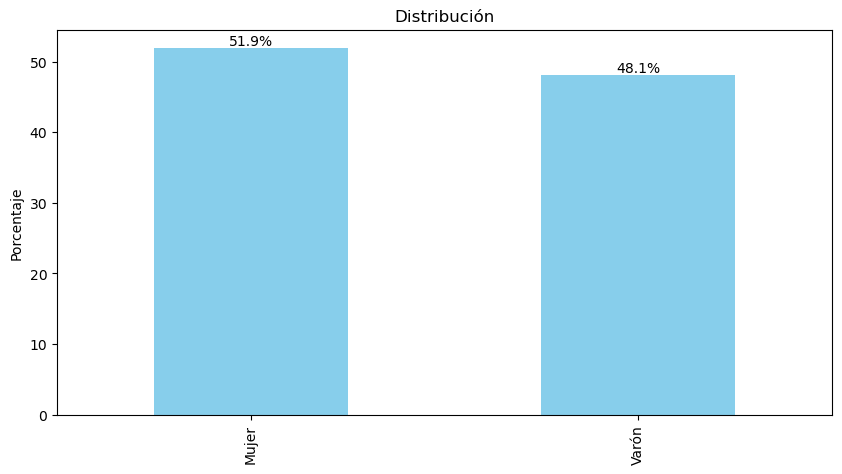

In [5]:
#2c) Gráfico de barras mostrando la composición por sexo
eph_indiv['gender'] = eph_indiv['CH04'].map({1: 'Varón', 2: 'Mujer'})
gender_counts = eph_indiv['gender'].value_counts(normalize=True) * 100
print(gender_counts) # Para conocer los porcentajes

# Gráfico de barras
barplot = plt.figure(figsize = (10, 5))
ax = gender_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución')
plt.ylabel('Porcentaje')

# Add percentage labels on top of the bars
for i, v in enumerate(gender_counts):
    ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.show()

              CH04      CH07      CH08  NIVEL_ED    ESTADO  CAT_INAC      IPCF
CH04      1.000000  0.000154 -0.018987  0.047994  0.109765  0.077415 -0.024086
CH07      0.000154  1.000000  0.072143 -0.069917  0.420460  0.412902 -0.043558
CH08     -0.018987  0.072143  1.000000  0.002025  0.021865  0.090299 -0.070840
NIVEL_ED  0.047994 -0.069917  0.002025  1.000000 -0.183746 -0.022259  0.148724
ESTADO    0.109765  0.420460  0.021865 -0.183746  1.000000  0.825380 -0.107224
CAT_INAC  0.077415  0.412902  0.090299 -0.022259  0.825380  1.000000 -0.110293
IPCF     -0.024086 -0.043558 -0.070840  0.148724 -0.107224 -0.110293  1.000000


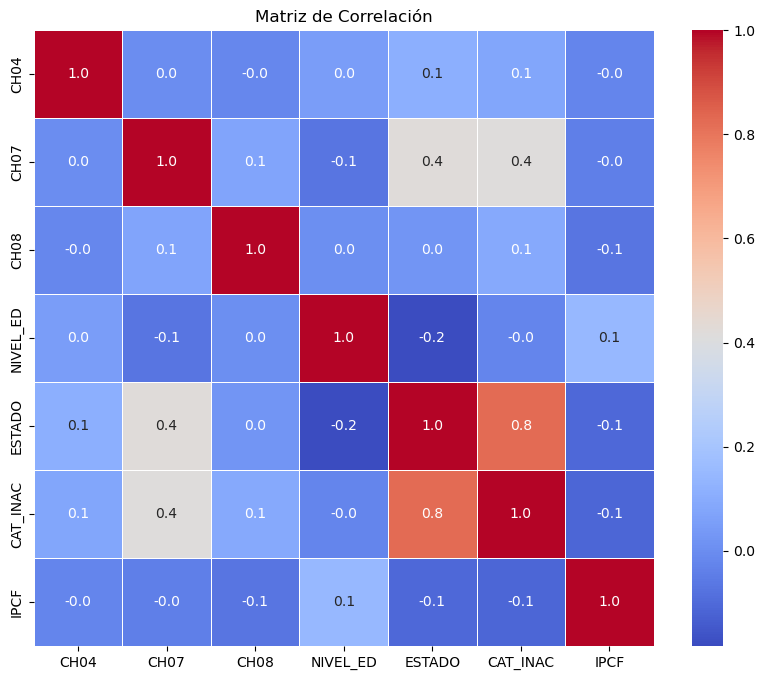

In [14]:
#2d) Matriz de correlación con las siguientes variables
covars = eph_indiv[['CH04', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'IPCF']] # Variables
corr_matrix = covars.corr()
print(corr_matrix) #Matriz de correlación

# Ahora hacemos un gráfico usando la librería 'seaborn'
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap= "coolwarm", fmt=".1f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

In [32]:
#2e) Calcular a los desocupados, inactivos y la media del Ingreso Per Capita Familiar segun estado (ocupado, desocupado, inactivo)

desocupados=(eph_indiv["ESTADO"] == 2).sum()
print("Número de desocupados en la muestra:" + str(desocupados))
inactivos = (eph_indiv["ESTADO"] == 3).sum()
print("Número de inactivos en la muestra:" + str(inactivos))

#Para calcular el ingreso per capita para cada grupo, usamos la función loc, ya que necesitamos seleccionar una columna en particular para aquellas filas que cumplen cierta condición.

ingreso_ipcf_ocupados= eph_indiv.loc[eph_indiv["ESTADO"] == 1, "IPCF"].mean()
print("La media del IPCF para los ocupados es:" + str(ingreso_ipcf_ocupados))

ingreso_ipcf_desocupados= eph_indiv.loc[eph_indiv["ESTADO"] == 2, "IPCF"].mean()
print("La media del IPCF para los desocupados es:" + str(ingreso_ipcf_desocupados))

ingreso_ipcf_inactivos= eph_indiv.loc[eph_indiv["ESTADO"] == 3, "IPCF"].mean()
print("La media del IPCF para los inactivos es:" + str(ingreso_ipcf_inactivos))


Número de desocupados en la muestra:286
Número de inactivos en la muestra:2837
La media de IPCF para los ocupados es:59579.44291512915
La media de IPCF para los desocupados es:25536.022202797205
La media de IPCF para los inactivos es:40067.99605216778


## Parte II: Clasificación

El objetivo de esta parte del trabajo es intentar predecir la condición de pobreza utilizando datos distintos al ingreso, dado que muchos hogares son reacios a responder
cuánto ganan.

### Inciso 1: Preparación de la base de datos

<span style="color:red">ADVERTENCIA</span>: el código del inciso 1 está "mal". Necesito tener las dos bases de datos que se crean en la parte I. Trabajé como si tuviera la base de datos. Luego modifico el código.

In [42]:
# Eliminamos de ambas bases todas las variables relacionadas a ingresos
respondieron = eph_indiv[eph_indiv["IPCF"] > 0].copy()
respondieron["IPCF"].describe() #Para corroborar. El valor mínimo es 6.25
respondieron["pobre"] = np.where(respondieron['IPCF'] < 57371.05, 1, 0) #MODIFICAR ESTO!

# Todas las variables que borraremos: 6 primeras filas son categorías de ingresos
dropvars = ["P21", "DECOCUR", "IDECOCUR", "RDECOCUR", "GDECOCUR", "PDECOCUR", "ADECOCUR", "PONDIIO", # Ocupación principal
            "TOT_P12", #Otra ocupaciones
            "P47T", "DECINDR", "IDECINDR", "RDECINDR", "GDECINDR", "PDECINDR", "ADECINDR", "PONDII", #Individual
            "V2_M", "V3_M", "V4_M", "V5_M", "V8_M", "V9_M", "V10_M", "V11_M", "V12_M", "V18_M", "V19_AM", "V21_M", "T_VI", #No laborales
            "ITF", "DECIFR", "IDECIFR", "RDECIFR", "GDECIFR", "PDECIFR", "ADECIFR", # Total Familiar
            "IPCF", "DECCFR", "IDECCFR", "RDECCFR", "GDECCFR", "PDECCFR", "ADECCFR", "PONDIH" #Per cap familiar
            # , adulto equiv,ad_equiv_hogar, ingreso_necesario # Otras variables
            ]


respondieron_new = respondieron.drop(columns=dropvars)

# Verificamos:
variable_names = respondieron_new.columns.tolist()
print("Nombre de las variables:")
for var_name in variable_names:
    print(var_name) #Todo OK!

Nombre de las variables:
CODUSU
ANO4
TRIMESTRE
NRO_HOGAR
COMPONENTE
H15
REGION
MAS_500
AGLOMERADO
PONDERA
CH03
CH04
CH05
CH06
CH07
CH08
CH09
CH10
CH11
CH12
CH13
CH14
CH15
CH15_COD
CH16
CH16_COD
NIVEL_ED
ESTADO
CAT_OCUP
CAT_INAC
IMPUTA
PP02C1
PP02C2
PP02C3
PP02C4
PP02C5
PP02C6
PP02C7
PP02C8
PP02E
PP02H
PP02I
PP03C
PP03D
PP3E_TOT
PP3F_TOT
PP03G
PP03H
PP03I
PP03J
INTENSI
PP04A
PP04B_COD
PP04B1
PP04B2
PP04B3_MES
PP04B3_ANO
PP04B3_DIA
PP04C
PP04C99
PP04D_COD
PP04G
PP05B2_MES
PP05B2_ANO
PP05B2_DIA
PP05C_1
PP05C_2
PP05C_3
PP05E
PP05F
PP05H
PP06A
PP06C
PP06D
PP06E
PP06H
PP07A
PP07C
PP07D
PP07E
PP07F1
PP07F2
PP07F3
PP07F4
PP07F5
PP07G1
PP07G2
PP07G3
PP07G4
PP07G_59
PP07H
PP07I
PP07J
PP07K
PP08D1
PP08D4
PP08F1
PP08F2
PP08J1
PP08J2
PP08J3
PP09A
PP09A_ESP
PP09B
PP09C
PP09C_ESP
PP10A
PP10C
PP10D
PP10E
PP11A
PP11B_COD
PP11B1
PP11B2_MES
PP11B2_ANO
PP11B2_DIA
PP11C
PP11C99
PP11D_COD
PP11G_ANO
PP11G_MES
PP11G_DIA
PP11L
PP11L1
PP11M
PP11N
PP11O
PP11P
PP11Q
PP11R
PP11S
PP11T
gender
pobre


### Inciso 2: Muestra de entrenamiento y test

<span style="color:red">ADVERTENCIA</span>: Esta parta también está "mal". Lo que hice fue definiar la variable "pobre" de la manera más simple posible. En la parte I se debería definir de mejor manera esta variable (con metodología de adultos equivalentes).

In [44]:
# Variable dependiente: pobre
print("Número de pobres:\n", respondieron_new.pobre.value_counts())
print("Porcentaje de pobres:\n", respondieron_new.pobre.value_counts(normalize=True) * 100)

Número de pobres:
 0    2146
1    2068
Name: pobre, dtype: int64
Porcentaje de pobres:
 0    50.925486
1    49.074514
Name: pobre, dtype: float64


In [115]:
# Dividimos la muestra en train y test
respondieron_new_nm = respondieron_new.dropna(axis=1, how='all') #Primero borramos los missings
X = respondieron_new_nm.drop(columns=["pobre"]) #Seleccionamos todas las variables excepto "pobre"
X = X.select_dtypes(include=['float64']) #Solo formato numérico
y = respondieron_new_nm["pobre"] # Cambié el nombre

# Hay variables que tienen al menos un missing value, lo que no permitirá correr la regresión logística
# Solución: Imputar la data usando la media
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Ahora si podemos particionar la muestra:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=201)

# Verificamos el número de observaciones para cada objeto
print("Muestra de entrenamiento. Obs:", "X=", len(X_train), "Y=", len(y_train))
print("Muestra de prueba. Obs:", "X=", len(X_test), "Y=", len(y_test))


Muestra de entrenamiento. Obs: X= 2949 Y= 2949
Muestra de prueba. Obs: X= 1265 Y= 1265


#### Modelo Logit

In [116]:
# Estimamos el modelo
# Puse más iteraciones porque no daba...
log_reg = LogisticRegression(max_iter=10000).fit(X_train, y_train)
y_test_pred_score = log_reg.predict_proba(X_test)[:,1]
y_test_pred = log_reg.predict(X_test)

In [117]:
# Matriz de confusión y accuracy
print('Matriz de confusión:\n', confusion_matrix(y_test, y_test_pred))
print('Accuracy Score:\n', accuracy_score(y_test, y_test_pred))

Matriz de confusión:
 [[460 172]
 [260 373]]
Accuracy Score:
 0.658498023715415


In [1]:
# Curva ROC y AUC score
auc = roc_auc_score(y_test, y_test_pred)
print('AUC: %.18f' % auc) 

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
np.set_printoptions(suppress = True)
print(thresholds)
print(fpr)
print(tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Reg_log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show()


NameError: name 'roc_auc_score' is not defined

#### KNN

#### Análisis de discriminante lineal